## **Content**

| Topic | Time |
|-|-|
| K-Means: Initialization | 15 mins|
| K-Means ++ | 25 mins |
| Limitations of K-Means | 15 mins |
| Kmedian Kmedioid | 20 Mins |




In last class, we grouped the customers of Amazon. In this class, we have another interesting use-case. Let's jump into it.

## **Problem Statement: Building Stock Portfolios**

**Goal :** Creating pools of stocks that move together(similar characteristics) on one or more fundamental financial metric.

In previous lecture we studied about K-Means clustering and how we can use it for customer segmentation.

In today's lecture we'll study some other clustering techniques, why they are required, what are the limitations of K-Means, and we'll use all this knowledge to build stock portfolios.

Let's first have a look at the dataset that we'll be using.

#### **Dataset - Top 50 NSE stocks**

- Contains company's stock symbol
- Name, Industry and other details

Lets import the dependencies

In [ ]:
  import pandas as pd
  import numpy as np
  from matplotlib import pyplot as plt
  plt.rcParams["figure.figsize"] = (18,10)
  import seaborn as sns

Reading the data

In [ ]:
!wget "https://drive.google.com/uc?export=download&id=1giO5bbp3l0INVvTQIGJ7s_Ai5_TWNuIb" -O ind_nifty50list.csv

--2022-11-18 10:25:12--  https://drive.google.com/uc?export=download&id=1giO5bbp3l0INVvTQIGJ7s_Ai5_TWNuIb
Resolving drive.google.com (drive.google.com)... 173.194.194.100, 173.194.194.138, 173.194.194.101, ...
Connecting to drive.google.com (drive.google.com)|173.194.194.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/q9rspdri1b647aag9ikgi2okp6btf1ar/1668767100000/10306167880925931714/*/1giO5bbp3l0INVvTQIGJ7s_Ai5_TWNuIb?e=download&uuid=f427ebb8-93a2-4046-9947-09c38c223910 [following]
--2022-11-18 10:25:13--  https://doc-08-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/q9rspdri1b647aag9ikgi2okp6btf1ar/1668767100000/10306167880925931714/*/1giO5bbp3l0INVvTQIGJ7s_Ai5_TWNuIb?e=download&uuid=f427ebb8-93a2-4046-9947-09c38c223910
Resolving doc-08-64-docs.googleusercontent.com (doc-08-64-docs.googleusercontent.com)... 209.85.147.132, 2

**Installing yfinance**


- **yfinance** is a library that helps us download market data from yahoo finance's api.

- So lets install these libraries into our environment using pip.

- You can read more about it <a href="https://pypi.org/project/yfinance/"> here </a>


In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
# Since yfinance is an old library, it also has some glitches, so we install this library as a fix
!pip install fix-yahoo-finance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### EDA
#### **Importing Data**

- Purpose of this dataset: Getting list of Company names which are stored in the 'Symbol' column of the data

In [ ]:
stocks_df = pd.read_csv("./ind_nifty50list.csv")
list_of_symbols = list(stocks_df['Symbol'])
stocks_df.head()

Company Name            Industry      Symbol  \
0  Adani Ports and Special Economic Zone Ltd.            SERVICES  ADANIPORTS   
1                           Asian Paints Ltd.      CONSUMER GOODS  ASIANPAINT   
2                              Axis Bank Ltd.  FINANCIAL SERVICES    AXISBANK   
3                             Bajaj Auto Ltd.          AUTOMOBILE  BAJAJ-AUTO   
4                          Bajaj Finance Ltd.  FINANCIAL SERVICES  BAJFINANCE   

  Series     ISIN Code  
0     EQ  INE742F01042  
1     EQ  INE021A01026  
2     EQ  INE238A01034  
3     EQ  INE917I01010  
4     EQ  INE296A01024

**Now, we'll take symbols from original dataset**
- We'll add `.NS` at the end of every symbol to fetch data from Yahoo Finance based on company's symbol.

In [ ]:
yf_symbols = list(map(lambda x: x + '.NS', list_of_symbols))
yf_symbols

['ADANIPORTS.NS',
 'ASIANPAINT.NS',
 'AXISBANK.NS',
 'BAJAJ-AUTO.NS',
 'BAJFINANCE.NS',
 'BAJAJFINSV.NS',
 'BPCL.NS',
 'BHARTIARTL.NS',
 'BRITANNIA.NS',
 'CIPLA.NS',
 'COALINDIA.NS',
 'DIVISLAB.NS',
 'DRREDDY.NS',
 'EICHERMOT.NS',
 'GRASIM.NS',
 'HCLTECH.NS',
 'HDFCBANK.NS',
 'HDFCLIFE.NS',
 'HEROMOTOCO.NS',
 'HINDALCO.NS',
 'HINDUNILVR.NS',
 'HDFC.NS',
 'ICICIBANK.NS',
 'ITC.NS',
 'IOC.NS',
 'INDUSINDBK.NS',
 'INFY.NS',
 'JSWSTEEL.NS',
 'KOTAKBANK.NS',
 'LT.NS',
 'M&M.NS',
 'MARUTI.NS',
 'NTPC.NS',
 'NESTLEIND.NS',
 'ONGC.NS',
 'POWERGRID.NS',
 'RELIANCE.NS',
 'SBILIFE.NS',
 'SHREECEM.NS',
 'SBIN.NS',
 'SUNPHARMA.NS',
 'TCS.NS',
 'TATACONSUM.NS',
 'TATAMOTORS.NS',
 'TATASTEEL.NS',
 'TECHM.NS',
 'TITAN.NS',
 'UPL.NS',
 'ULTRACEMCO.NS',
 'WIPRO.NS']

**Now, we'll define some variables and fetch the corresponding data from Yahoo Finance for the companies in our list**

In [ ]:
import yfinance as yf


stock_financials = {
    'marketCap': [],
    'regularMarketVolume': [],
    'earningsQuarterlyGrowth': [],
    'bookValue': [],
    'totalRevenue': [],
    'returnOnAssets': [],
    'profitMargins': [],
    'earningsGrowth': []
    }

for ticker in yf_symbols:
    stock_info = yf.Ticker(ticker).info
    stock_financials['marketCap'].append(stock_info['marketCap'])
    stock_financials['regularMarketVolume'].append(stock_info['regularMarketVolume'])
    stock_financials['earningsQuarterlyGrowth'].append(stock_info['earningsQuarterlyGrowth'])
    stock_financials['bookValue'].append(stock_info['bookValue'])
    stock_financials['totalRevenue'].append(stock_info['totalRevenue'])
    stock_financials['returnOnAssets'].append(stock_info['returnOnAssets'])
    stock_financials['profitMargins'].append(stock_info['profitMargins'])
    stock_financials['earningsGrowth'].append(stock_info['earningsGrowth'])

KeyError: ignored

**Q. What have we collected?**
We 've collected attributes such as '**marketCap**', '**regularMarketVolume**' and others for companies that we collected in variable '**yf_symbols**'

In [ ]:
df = pd.DataFrame(stock_financials)
df.head()

marketCap  regularMarketVolume  earningsQuarterlyGrowth  bookValue  \
0  1657751076864             12901505                   -0.179    180.288   
1  3167850856448               933762                    0.789    143.991   
2  2221430013952              6403035                    0.859    400.581   
3   996960239616               442625                   -0.006   1033.043   
4  4343084089344               819955                    1.590    724.584   

   totalRevenue  returnOnAssets  profitMargins  earningsGrowth  
0  159007899648             NaN        0.28442          -0.207  
1  319870205952             NaN        0.10876           0.788  
2  433654104064         0.01474        0.37225           0.855  
3  348966289408             NaN        0.17649          -0.007  
4  202325999616             NaN        0.42614           1.586

In [ ]:
df.shape

(50, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   marketCap                50 non-null     int64  
 1   regularMarketVolume      50 non-null     int64  
 2   earningsQuarterlyGrowth  47 non-null     float64
 3   bookValue                49 non-null     float64
 4   totalRevenue             50 non-null     int64  
 5   returnOnAssets           18 non-null     float64
 6   profitMargins            50 non-null     float64
 7   earningsGrowth           47 non-null     float64
dtypes: float64(5), int64(3)
memory usage: 3.2 KB


**Downloading stock price data**
- Purpose of this data: Getting returns of the stocks

In [ ]:
import yfinance as yf

stock_prices = yf.download(yf_symbols, start='2020-01-01')['Adj Close']
stock_prices.columns = list_of_symbols

[*********************100%***********************]  50 of 50 completed


 - 'Adj Close' refers to Adjusted close which is used in stock market. It is the closing price after adjustments for all applicable splits and dividend distributions

In [ ]:
stock_prices.shape

(686, 50)

In [ ]:
stock_prices.tail()

ADANIPORTS   ASIANPAINT    AXISBANK   BAJAJ-AUTO   BAJFINANCE  \
Date                                                                        
2022-09-27  844.200012  3470.649902  737.500000  3541.899902  1679.550049   
2022-09-28  827.099976  3570.649902  716.450012  3545.899902  1652.199951   
2022-09-29  816.400024  3384.800049  719.000000  3476.699951  1635.900024   
2022-09-30  820.650024  3342.449951  733.200012  3527.750000  1678.349976   
2022-10-03  784.400024  3302.899902  722.750000  3515.350098  1646.599976   

             BAJAJFINSV        BPCL  BHARTIARTL    BRITANNIA        CIPLA  \
Date                                                                        
2022-09-27  7242.850098  760.599976  310.649994  3824.149902  1098.699951   
2022-09-28  7202.500000  761.450012  306.000000  3853.199951  1097.150024   
2022-09-29  7104.750000  764.650024  303.250000  3864.500000  1115.849976   
2022-09-30  7335.750000  799.900024  304.799988  3843.050049  1114.949951   
2022-10-03  7171.799805  803.349976  308.799988  3768.949951  1130.750000   

            ...   SUNPHARMA         TCS  TATACONSUM  TATAMOTORS    TATASTEEL  \
Date        ...                                                                
2022-09-27  ...  897.150024  797.849976  398.799988   97.650002  3017.449951   
2022-09-28  ...  917.849976  793.650024  399.100006   95.199997  3035.649902   
2022-09-29  ...  930.700012  792.599976  402.250000   96.849998  2997.300049   
2022-09-30  ...  948.650024  802.849976  404.600006   99.300003  3004.550049   
2022-10-03  ...  944.500000  777.950012  397.649994   98.349998  2984.949951   

                  TECHM        TITAN          UPL  ULTRACEMCO       WIPRO  
Date                                                                       
2022-09-27  1022.500000  2600.350098  6192.850098  677.700012  398.399994  
2022-09-28  1029.699951  2576.949951  6172.950195  663.700012  398.049988  
2022-09-29  1007.099976  2531.500000  6175.899902  656.799988  392.799988  
2022-09-30  1008.599976  2606.949951  6255.100098  672.049988  394.250000  
2022-10-03  1005.500000  2574.199951  6242.549805  665.099976  394.500000  

[5 rows x 50 columns]

In [ ]:
# splitting data by year - 2020 returns
price_2020 = stock_prices.loc["2020-01-02 00:00:00":"2020-12-31 00:00:00"]

# to see % growth of the stock: ((endDate/startDate) - 1) * 100
stock_prices.loc['returns_2020'] = (price_2020.loc['2020-08-04 00:00:00'] / price_2020.loc['2020-01-02 00:00:00'] - 1)*100

stock_prices

ADANIPORTS   ASIANPAINT    AXISBANK   BAJAJ-AUTO  \
Date                                                                    
2020-01-01 00:00:00  373.521973  1770.856567  748.700012  2913.946289   
2020-01-02 00:00:00  378.961853  1768.338379  756.950012  2887.027588   
2020-01-03 00:00:00  378.318970  1729.577393  742.950012  2841.747314   
2020-01-06 00:00:00  376.044098  1685.878784  723.250000  2809.926025   
2020-01-07 00:00:00  380.593811  1702.913940  725.750000  2810.203613   
...                         ...          ...         ...          ...   
2022-09-28 00:00:00  827.099976  3570.649902  716.450012  3545.899902   
2022-09-29 00:00:00  816.400024  3384.800049  719.000000  3476.699951   
2022-09-30 00:00:00  820.650024  3342.449951  733.200012  3527.750000   
2022-10-03 00:00:00  784.400024  3302.899902  722.750000  3515.350098   
returns_2020         -16.891368    -3.813726  -43.305372    -0.566448   

                      BAJFINANCE   BAJAJFINSV        BPCL  BHARTIARTL  \
Date                                                                    
2020-01-01 00:00:00   930.323730  4214.786133  451.678009  401.235748   
2020-01-02 00:00:00   942.936829  4229.478516  453.571259  397.889709   
2020-01-03 00:00:00   927.089966  4177.084473  453.471588  394.584534   
2020-01-06 00:00:00   897.018066  3981.102051  448.041077  382.873505   
2020-01-07 00:00:00   902.270569  3992.009277  443.507385  376.222229   
...                          ...          ...         ...         ...   
2022-09-28 00:00:00  1652.199951  7202.500000  761.450012  306.000000   
2022-09-29 00:00:00  1635.900024  7104.750000  764.650024  303.250000   
2022-09-30 00:00:00  1678.349976  7335.750000  799.900024  304.799988   
2022-10-03 00:00:00  1646.599976  7171.799805  803.349976  308.799988   
returns_2020          -34.809406   -23.622259   20.606316  -11.615303   

                       BRITANNIA        CIPLA  ...   SUNPHARMA         TCS  \
Date                                           ...                           
2020-01-01 00:00:00  2883.702881   472.062744  ...  422.185242  319.631714   
2020-01-02 00:00:00  2896.747314   469.682129  ...  422.817108  319.138245   
2020-01-03 00:00:00  2882.896729   466.160767  ...  432.197937  314.055328   
2020-01-06 00:00:00  2867.005859   462.986542  ...  427.677612  308.034790   
2020-01-07 00:00:00  2880.809570   464.821655  ...  433.947723  310.798309   
...                          ...          ...  ...         ...         ...   
2022-09-28 00:00:00  3853.199951  1097.150024  ...  917.849976  793.650024   
2022-09-29 00:00:00  3864.500000  1115.849976  ...  930.700012  792.599976   
2022-09-30 00:00:00  3843.050049  1114.949951  ...  948.650024  802.849976   
2022-10-03 00:00:00  3768.949951  1130.750000  ...  944.500000  777.950012   
returns_2020           26.413111    51.151863  ...   22.489657   40.114331   

                     TATACONSUM  TATAMOTORS    TATASTEEL        TECHM  \
Date                                                                    
2020-01-01 00:00:00  184.449997   27.305548  2100.150635   705.708984   
2020-01-02 00:00:00  193.750000   28.303785  2090.509521   709.366638   
2020-01-03 00:00:00  191.100006   28.236650  2132.171631   717.747009   
2020-01-06 00:00:00  185.649994   27.626617  2131.977783   713.394836   
2020-01-07 00:00:00  184.699997   27.792992  2137.209717   719.599121   
...                         ...         ...          ...          ...   
2022-09-28 00:00:00  399.100006   95.199997  3035.649902  1029.699951   
2022-09-29 00:00:00  402.250000   96.849998  2997.300049  1007.099976   
2022-09-30 00:00:00  404.600006   99.300003  3004.550049  1008.599976   
2022-10-03 00:00:00  397.649994   98.349998  2984.949951  1005.500000   
returns_2020         -42.477421  -23.223682     5.812786   -12.938676   

                           TITAN          UPL  ULTRACEMCO       WIPRO  
Date                                                                   
2020-01-01 0

In [ ]:
stock_prices = stock_prices.transpose()
stock_prices.head()

Date        2020-01-01 00:00:00  2020-01-02 00:00:00  2020-01-03 00:00:00  \
ADANIPORTS           373.521973           378.961853           378.318970   
ASIANPAINT          1770.856567          1768.338379          1729.577393   
AXISBANK             748.700012           756.950012           742.950012   
BAJAJ-AUTO          2913.946289          2887.027588          2841.747314   
BAJFINANCE           930.323730           942.936829           927.089966   

Date        2020-01-06 00:00:00  2020-01-07 00:00:00  2020-01-08 00:00:00  \
ADANIPORTS           376.044098           380.593811           381.434509   
ASIANPAINT          1685.878784          1702.913940          1707.259033   
AXISBANK             723.250000           725.750000           724.500000   
BAJAJ-AUTO          2809.926025          2810.203613          2829.906982   
BAJFINANCE           897.018066           902.270569           907.215576   

Date        2020-01-09 00:00:00  2020-01-10 00:00:00  2020-01-13 00:00:00  \
ADANIPORTS           387.517273           387.764557           386.083160   
ASIANPAINT          1750.463867          1770.214722          1782.410889   
AXISBANK             742.849976           740.049988           737.400024   
BAJAJ-AUTO          2854.374023          2868.711914          2862.098145   
BAJFINANCE           931.990356           929.708740           937.942200   

Date        2020-01-14 00:00:00  ...  2022-09-21 00:00:00  \
ADANIPORTS           384.945740  ...           932.900024   
ASIANPAINT          1796.483398  ...          3356.050049   
AXISBANK             747.900024  ...           806.549988   
BAJAJ-AUTO          2869.082275  ...          3730.600098   
BAJFINANCE           947.822266  ...          1802.000000   

Date        2022-09-22 00:00:00  2022-09-23 00:00:00  2022-09-26 00:00:00  \
ADANIPORTS           946.650024           913.799988           863.400024   
ASIANPAINT          3436.000000          3395.250000          3438.050049   
AXISBANK             789.200012           768.599976           742.599976   
BAJAJ-AUTO          3728.899902          3698.899902          3574.500000   
BAJFINANCE          1772.349976          1721.900024          1676.800049   

Date        2022-09-27 00:00:00  2022-09-28 00:00:00  2022-09-29 00:00:00  \
ADANIPORTS           844.200012           827.099976           816.400024   
ASIANPAINT          3470.649902          3570.649902          3384.800049   
AXISBANK             737.500000           716.450012           719.000000   
BAJAJ-AUTO          3541.899902          3545.899902          3476.699951   
BAJFINANCE          1679.550049          1652.199951          1635.900024   

Date        2022-09-30 00:00:00  2022-10-03 00:00:00  returns_2020  
ADANIPORTS           820.650024           784.400024    -16.891368  
ASIANPAINT          3342.449951          3302.899902     -3.813726  
AXISBANK             733.200012           722.750000    -43.305372  
BAJAJ-AUTO          3527.750000          3515.350098     -0.566448  
BAJFINANCE          1678.349976          1646.599976    -34.809406  

[5 rows x 687 columns]

**Putting the data together**

In [ ]:
prices = stock_prices.iloc[:, -1]
df.index = stock_prices.index
df['return_2020'] = prices
df.head()

marketCap  regularMarketVolume  earningsQuarterlyGrowth  \
ADANIPORTS  1657751076864             12901505                   -0.179   
ASIANPAINT  3167850856448               933762                    0.789   
AXISBANK    2221430013952              6403035                    0.859   
BAJAJ-AUTO   996960239616               442625                   -0.006   
BAJFINANCE  4343084089344               819955                    1.590   

            bookValue  totalRevenue  returnOnAssets  profitMargins  \
ADANIPORTS    180.288  159007899648             NaN        0.28442   
ASIANPAINT    143.991  319870205952             NaN        0.10876   
AXISBANK      400.581  433654104064         0.01474        0.37225   
BAJAJ-AUTO   1033.043  348966289408             NaN        0.17649   
BAJFINANCE    724.584  202325999616             NaN        0.42614   

            earningsGrowth  return_2020  
ADANIPORTS          -0.207   -16.891368  
ASIANPAINT           0.788    -3.813726  
AXISBANK             0.855   -43.305372  
BAJAJ-AUTO          -0.007    -0.566448  
BAJFINANCE           1.586   -34.809406

**Checking for null values**

In [ ]:
df.isna().sum()

marketCap                   0
regularMarketVolume         0
earningsQuarterlyGrowth     3
bookValue                   1
totalRevenue                0
returnOnAssets             32
profitMargins               0
earningsGrowth              3
return_2020                 0
dtype: int64

In [ ]:
df['returnOnAssets'] = df['returnOnAssets'].replace(np.nan, 0)

In [ ]:
df.dropna(axis=0, inplace=True)
df.shape

(46, 9)

In [ ]:
df.head()

marketCap  regularMarketVolume  earningsQuarterlyGrowth  \
ADANIPORTS  1657751076864             12901505                   -0.179   
ASIANPAINT  3167850856448               933762                    0.789   
AXISBANK    2221430013952              6403035                    0.859   
BAJAJ-AUTO   996960239616               442625                   -0.006   
BAJFINANCE  4343084089344               819955                    1.590   

            bookValue  totalRevenue  returnOnAssets  profitMargins  \
ADANIPORTS    180.288  159007899648         0.00000        0.28442   
ASIANPAINT    143.991  319870205952         0.00000        0.10876   
AXISBANK      400.581  433654104064         0.01474        0.37225   
BAJAJ-AUTO   1033.043  348966289408         0.00000        0.17649   
BAJFINANCE    724.584  202325999616         0.00000        0.42614   

            earningsGrowth  return_2020  
ADANIPORTS          -0.207   -16.891368  
ASIANPAINT           0.788    -3.813726  
AXISBANK             0.855   -43.305372  
BAJAJ-AUTO          -0.007    -0.566448  
BAJFINANCE           1.586   -34.809406

**Q. Should we Scale the values?**

- The data seems to be in different scales
- Different financial metrics have different scales.
- We need to put them on the same scale.

We can use `StandardScaler` from `sklearn`

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df)
X = scaler.transform(df)

In [ ]:
scaled_df = pd.DataFrame(X, columns=df.columns, index=df.index)

In [ ]:
scaled_df

marketCap  regularMarketVolume  earningsQuarterlyGrowth  \
ADANIPORTS  -0.383732             0.817828                -0.719520   
ASIANPAINT   0.133385            -0.496196                 0.330622   
AXISBANK    -0.190706             0.104314                 0.406562   
BAJAJ-AUTO  -0.610013            -0.550122                -0.531840   
BAJFINANCE   0.535830            -0.508692                 1.199593   
BAJAJFINSV  -0.053153            -0.438011                 0.095208   
BHARTIARTL   0.686134             0.786739                 4.538784   
BRITANNIA   -0.640379            -0.571071                -0.670701   
CIPLA       -0.638859            -0.313085                -0.568725   
COALINDIA   -0.497789             0.652575                 1.413310   
DIVISLAB    -0.612614            -0.538381                -0.243267   
DRREDDY     -0.700281            -0.522387                 0.647400   
EICHERMOT   -0.627096            -0.359370                 1.183320   
GRASIM      -0.582465            -0.546789                -0.351753   
HCLTECH     -0.086961            -0.423217                -0.552452   
HDFCBANK     1.744086             0.034762                -0.298595   
HDFCLIFE    -0.569969            -0.274826                -0.430948   
HEROMOTOCO  -0.778595            -0.526421                 0.890409   
HINDALCO    -0.660390             0.334443                -0.006769   
HINDUNILVR   1.158944            -0.413938                -0.378875   
HDFC         0.469387            -0.324318                -0.467833   
ICICIBANK    1.072559             0.305064                 0.076765   
ITC          0.417472             0.401375                -0.398402   
INDUSINDBK  -0.642053            -0.225658                 0.131008   
INFY         1.048593            -0.056099                -0.548112   
JSWSTEEL    -0.436747            -0.457534                -1.456138   
KOTAKBANK    0.261632            -0.330851                 0.045305   
LT          -0.076196            -0.395568                -0.038229   
MARUTI      -0.067275            -0.475450                 0.755886   
NTPC        -0.418966             0.557034                -0.358262   
NESTLEIND   -0.324342            -0.593009                -0.571979   
ONGC        -0.380811             4.996544                 0.553018   
POWERGRID   -0.447998             0.367653                -0.922388   
RELIANCE     4.538575             0.001660                -0.058842   
SBILIFE     -0.527410            -0.490933                -0.332226   
SHREECEM    -0.695418            -0.587875                -1.128511   
SBIN         0.637015             0.427705                 0.081105   
SUNPHARMA   -0.164962            -0.110742                -0.062096   
TCS          2.829622            -0.405165                -0.468918   
TATACONSUM  -0.702952            -0.417316                 2.768297   
TATASTEEL   -0.909588             3.493634                -0.664192   
TECHM       -0.617159            -0.331801                -0.703247   
TITAN       -0.168822            -0.483537                -0.629477   
UPL         -0.777395            -0.399361                -0.203128   
ULTRACEMCO  -0.328850            -0.561628                -0.601270   
WIPRO       -0.213290            -0.151982                -0.749896   

            bookValue  totalRevenue  returnOnAssets  profitMargins  \
ADANIPORTS  -0.484327     -0.642720       -0.504524       1.205336   
ASIANPAINT  -0.540867     -0.507665       -0.504524      -0.508547   
AXISBANK    -0.141175     -0.412136       -0.250331       2.062278   
BAJAJ-AUTO   0.844016     -0.483237       -0.504524       0.152283   
BAJFINANCE   0.363527     -0.606352       -0.504524       2.588073   
BAJAJFINSV  -0.371209     -0.197357       -0.504524      -0.857451   
BHARTIARTL  -0.588886      0.256575       -0.504524      -1.127227   
BRITANNIA   -0.599730     -0.655394       -0.504524      -0.571283   
CIPLA       -0.362774     -0.594584       -0

What we can do now is we can apply K-Means to solve this use-case as well. But, let's first see what are some drawbacks and limitations of K-Means.

---

## **K-Means Intitialization**

- K-Means is **Initialization dependent**. This is one of the major drawbacks of K-Means.

- This means, that the same data, with different initialization, will get different results (different clusters)

<img src='https://drive.google.com/uc?id=1KGZH4R5spf-nbx975TVct8POa7i8m3Wm'>




Images shown below can be found here: https://cs.wmich.edu/alfuqaha/summer14/cs6530/lectures/ClusteringAnalysis.pdf

Alternative link: https://drive.google.com/file/d/1ok4aGA1AZna3XyodOrLO8DYbZImpI7l9/view?usp=sharing

The docoument belongs to folks at University of Michigan.

#### This is how K-Means would give different results with different initializations

<img src="https://drive.google.com/uc?export=view&id=1_8XrEVwmo47dHUkJfNKXXtF1CQE5eMG2">

* In Optimal Clustering results, results are sensible
* In Sub-Optimal Clustering, which probably doesn't make sense and won't be an optimal one




Use this <a href ="https://www.naftaliharris.com/blog/visualizing-k-means-clustering/">visualization tool </a> for intuitive explanation of K-Means initialization problem. While choosing. You can play around with different options, and can use whatever suits best

Using Python, let's see how random initialization gives different results over same data.

#####**K-Means Random-State 1**

In [ ]:
from sklearn.cluster import KMeans

km1 = KMeans(n_clusters = 3, init='random')
y_km = km1.fit_predict(scaled_df)
viz_df = scaled_df
viz_df['y_km'] = y_km

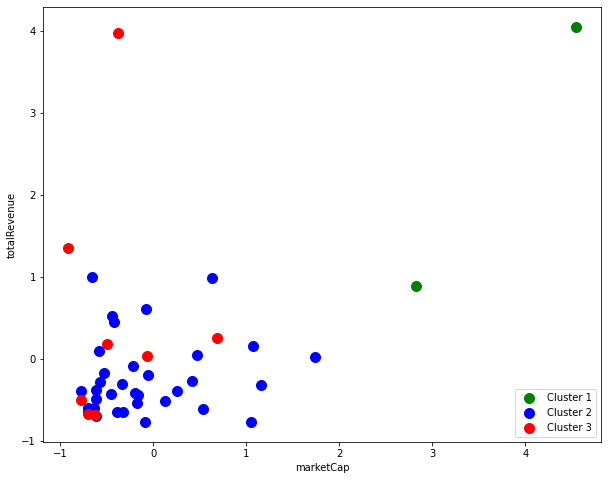

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(viz_df[viz_df['y_km'] == 0]['marketCap'], viz_df[viz_df['y_km'] == 0]['totalRevenue'], s=100, c='Green', label='Cluster 1')
plt.scatter(viz_df[viz_df['y_km'] == 1]['marketCap'], viz_df[viz_df['y_km'] == 1]['totalRevenue'], s=100, c='Blue', label='Cluster 2')
plt.scatter(viz_df[viz_df['y_km'] == 2]['marketCap'], viz_df[viz_df['y_km'] == 2]['totalRevenue'], s=100, c='Red', label='Cluster 3')
plt.xlabel('marketCap')
plt.ylabel('totalRevenue')
plt.legend()
plt.show()

#####**K-Means Random-State 2**

In [ ]:
km2 = KMeans(n_clusters = 3, init='random')
y_km2 = km2.fit_predict(scaled_df)
viz_df['y_km2'] = y_km2

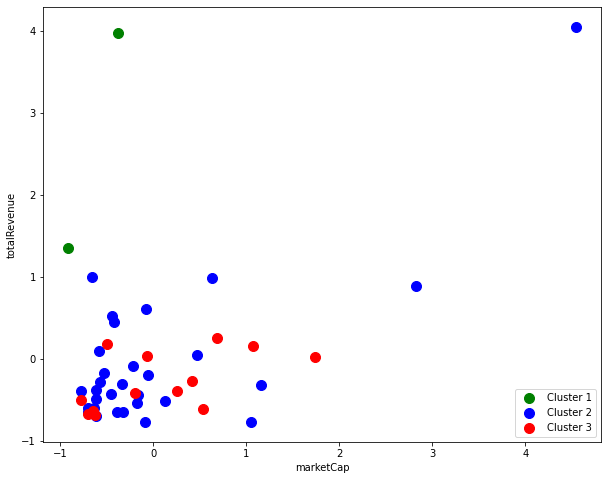

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(viz_df[viz_df['y_km2'] == 0]['marketCap'], viz_df[viz_df['y_km2'] == 0]['totalRevenue'], s=100, c='Green', label='Cluster 1')
plt.scatter(viz_df[viz_df['y_km2'] == 1]['marketCap'], viz_df[viz_df['y_km2'] == 1]['totalRevenue'], s=100, c='Blue', label='Cluster 2')
plt.scatter(viz_df[viz_df['y_km2'] == 2]['marketCap'], viz_df[viz_df['y_km2'] == 2]['totalRevenue'], s=100, c='Red', label='Cluster 3')
plt.xlabel('marketCap')
plt.ylabel('totalRevenue')
plt.legend()
plt.show()

#####**K-Means Random-State 3**

In [ ]:
km3 = KMeans(n_clusters = 3, init='random')
y_km3 = km3.fit_predict(scaled_df)
viz_df['y_km3'] = y_km3

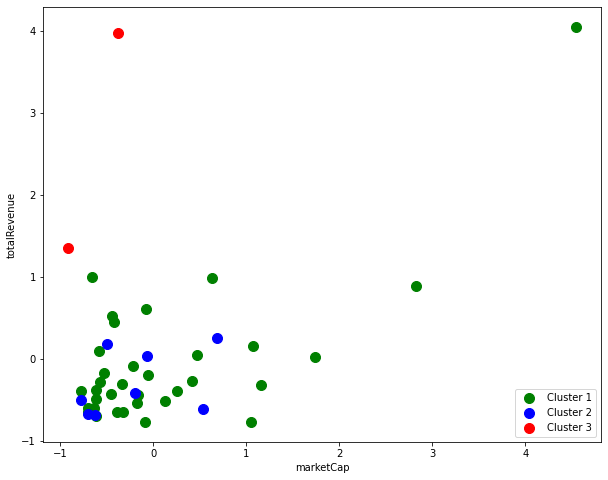

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(viz_df[viz_df['y_km3'] == 0]['marketCap'], viz_df[viz_df['y_km3'] == 0]['totalRevenue'], s=100, c='Green', label='Cluster 1')
plt.scatter(viz_df[viz_df['y_km3'] == 1]['marketCap'], viz_df[viz_df['y_km3'] == 1]['totalRevenue'], s=100, c='Blue', label='Cluster 2')
plt.scatter(viz_df[viz_df['y_km3'] == 2]['marketCap'], viz_df[viz_df['y_km3'] == 2]['totalRevenue'], s=100, c='Red', label='Cluster 3')
plt.xlabel('marketCap')
plt.ylabel('totalRevenue')
plt.legend()
plt.show()

#### **Q. Why it is important to choose good Initial Centroids?**

1. Good Initialization

 * Suppose you've initialized three centroids C1, C2, and C3
 * We know that centroids get updated after each iteration
 * When they don't, we conclude that K-Means has converged
 * The diagram shows three such clusters: S1, S2 and S3
 * This seems like a good initialization

<img src="https://drive.google.com/uc?export=view&id=1bP-rLsBKfqHmWCiqynzXvjfVwmX0jBii">


2. Bad Initialization:
  * Suppose we've initialized three clusters C1, C2, and C3 in different way
  * After iteration 4, the centroids didn't get updated
  * We conclude that K-Means has converged after 5 iterations
  * We've still clustered datapoints into 3 groups, but they are not optimal


<img src="https://drive.google.com/uc?export=view&id=1j7WfPAxskKBQ08fMY68RdX03uB52wDOR">

#### **Q. So, how to deal with initialization problem in K-Means?**

- Remember dunn index from previous lecture;
  $D = \Large\frac{min_{i,j} distance(i,j)}{max_k distance^{'}(k)}$; where,

    - distance(i,j) → distance between the farthest points of the clusters $C_i$ and $C_j$ → **Inter-Cluster distance**

- We also learnt Lloyd's Algorithm in the previous lecture in which we randomly intialize the centroids and based on the distances of centroids, we keep updating them until convergence.

- One way to deal with initialization problem would be to try different initializations for Lloyd's Algorithm and pick the best one out of it based on Dunn Index or any other evaluation metric

- But, this is a brute force approach

- This brings us to another algorithm: **K-Means++**


<img src="https://drive.google.com/uc?export=view&id=1XhLKZp7aPuWJ45wEL2SaCQEYaYYkuto9">
<img src="https://drive.google.com/uc?export=view&id=1dZgwmRPZLfZ2Z_MgHbRHqDhUvPQu5Thm">

## **K-Means ++**



* Consider a data where we want to initialize 3 centroids.
* We pick first centroid at random
* Now, to pick the second centroid, we want to pick a point that is as far away as possible

#### Why pick a centroid that is far away?
- Because, if you think about it, if we pick two centroids closer to each other, we'll get two clusters for that region of data points.

**Q. But, what's the problem in getting two clusters instead of a single one?**

- Most of the times data points belonging to the same region will share similar characteristics and they should ideally belong to one cluster, instead of two.

- So, what we do is compute the distance from centroid $C_{1}$ of all the datapoints present in our dataset $D$ such as: $D$ - {$C_{1}$}

- But there's a little risk with this.

- If we select a datapoint as a second centroid with the farthest distance, then an outlier might be picked as a centroid, and we might have a cluster with the centroid $C_{2}$ only

#### Q. Is there a way to avoid picking an outlier as a centroid?
- Yes! Instead of picking a centroid deterministically, we can pick a centroid probabilistically

- We do this in such a way that the probability of picking a centroid is proportional to the distance from the first centroid $C_{1}$

- This concept works really well unless there is an outlier with crazy high values

<img src="https://drive.google.com/uc?export=view&id=1ynRdMdJltByaY2PdZdJmFpDNWZcwXubo">

#### Now, how to pick next centroids?
- For all points, we will compute the distance: dist($C_{1}, X_{i}$) + dist($C_{2}, X_{i}$) such that $X_{i} \in D$ - ${C_{1}, C_{2} }$
- This will distances from both $C_{1}$ and $C_{2}$ (average them)
- Now, pick a point probabilistcally

- So, for picking $K$ centroids, we pick first centroid randomly, and then we pick ${i}^{th}$ centroid in the probabilistic fashion as a point which has the highest from all the previously chosen centroids.

#### What type of distance to use?
- Any type of distance can be used for K-Means ++. For e.g. Euclidean Distance, Cosine Similarity or an Angular difference
- The basic idea remains the same.

We saw how K-Means++ can be used instead of K-Means to solve the problem of **Initialization**. So, can we use K-Means++ all the time regardless of the business case that we want to solve.

NO! There are other limitations of K-Means++, which by default will also apply to K-Means as well. Let's have a look at them.

## **Limitation of KMeans/KMeans++**


##### **Differing Size**

- Because of the way Lloyd's algorthm work, K-Means always tries to make clusters of same size

<img src="https://drive.google.com/uc?export=view&id=1DKEwQtMCsrBcstUzLOlX06wkMBvJjiCO">

> Q. How can we solve this?

- One way of solving this problem would be to increase the value of K.
- Once clusters are formed, the similar clusters can be grouped together to form a mega cluster.
- The problem with this approach is the grouping of similar clusters is not easy

<img src="https://drive.google.com/uc?export=view&id=1GMiOosbfxOt4O3G-uplE5Iu7Xt24BZmd">
<img src="https://drive.google.com/uc?export=view&id=1x-XLirB4SUdnaqfnmxaYZOXWlpxF-RwL">

##### **Differing Density**

- K-Means is not good when you've clusters of different density, not even K-Means ++

<img src="https://drive.google.com/uc?export=view&id=18s3PCi_JVCaxSqgXSJmewy9wP26GeGM2">

#### **Non-Globular Shapes**

- Another limitation of K-Means is that it cannot work on non-globular shapes, i.e. Non- spherical shapes

<img src="https://drive.google.com/uc?export=view&id=15ELbeS7zULGstT8Zsx3fF-AB1L7eSh_L">

- The same strategy of increasing $K$ value can be applied.
- Though it is fairly hard to visualize and combine clusters

<img src="https://drive.google.com/uc?export=view&id=1afKW-pXFDVFUJwslqsspJ5HcNWbvqM_2">

#### Q. What are some Hacks for dealing with Non-Globular Shapes?

- For dealing with the problem of differing densities and non-globular shapes, same idea of increasing the value of $K$, and then combining similar clusters can be applied

- This is fairly hard to combine let alone visualize in multi-dimensional space

**Note:** These limitations are also shared by KMeans++.

We saw that how Kmeans is impacted by outlier.


However,
Using Kmeans++ initialization helps us
- with mitigating this problem.

Apart from Kmeans++,
- there are other methods as well which can help us in addressing this issue.

## KMedian and KMedoid

## K-median

The algo is similar to Kmeans

Let's look into it.

#### Algo

**STEP 1: Initialization**

First, we initialize the cluster centers. (another name for centroids)

**STEP 2: Repeat until convergence**

$ $

1. Assignment
    - each of the point is assigned to the closest cluster

2. Update cluster center


For Kmeans,
-  centroid update equation was: $C_j = \frac{1}{|S_j|} * Σ_{x_i∈S_j} x_i$
- i.e. taking the mean of all the points belonging to the cluster to compute new centroid.
    
In Kmedian,
- instead of find the mean, we find the median.

#### Why Kmedian is less sensitive to outliers ?

Since we are using median to find the updated cluster center,
- and median is less sensitive to outliers as compared to mean

This makes Kmeans less sensitive to outlier

### Issue with the algos so far

There's one basic problem with the algos we have learnt so far





At the end of it,
- we get centroid $C_1, C_2, C_3, ... C_k$


Originally, we are given
- Dataset $D$ = {x_1, x_2, x_3, .. x_n}

Since, centroid represent the clusters,
- we will want to interpret the centroid

Using the Kmeans, Kmeans++ or Kmedian, there centroid
- may **not be interpretable**



Let's understand this with an example:

Say, we are given Amazon customer data where
- $x_i$ represent each customer

Now,
- The centroids $C_1, C_2, .. C_k$
    - were computed using geometric mean / median

So, it is highly likely that these centroid
- is not a datapoints present in dataset (as we took the mean)

and we can't make a sense out of it.

#### How can we deal with issue ?

**Requirement**:

Instead of getting $C_j$s centroids computed using mean/median
- we want actual datapoints ($x_i$ ∈ D) belonging to dataset as our centroids

Ultimately,
- we want to make sense out of centroid

which can be satisfied if it is an actual datapoint

**Big idea** is: What if each centroid is a datapoint in $D$?

- The system where this happens is called **K-medoids**

## K-medoids

Just like we have Lloyd's algo for Kmeans,
- there is **Partioning around medoids** (PAM) for K-medoids


It is quite similar to Kmeans with few differences

Let's see how it works

**Step 1:** Initialization

The initialization of centroids (called medoids in K-medoids) is on same ideas as K-means
- i.e. we pick $k$ points randomly from dataset as our initial medoids.

**Step 2**: Assignment

Assignment is quite same as kmeans
- We use closest medoid method (proximity)

A datpoint ($x_i$) belongs to cluster $S_j$ if
- $medoid_j$ is the cosest medoid

**Step 3**: Update/ recompute

In kmeans,
- we took the mean of points to find new centroid

$C_j = \frac{1}{|S_j|} * Σ_{x_i∈S_j} x_i$


But we don't want to do mean approach.

- So, we change this approach slightly

In k-medoids,

The Update of medoid is as follows



1.   Swap each medoid with a non medoid point




Let's understand this:

Say, we are given 10 datapoints and we choose two datapoints as medoids

i.e. k = 2

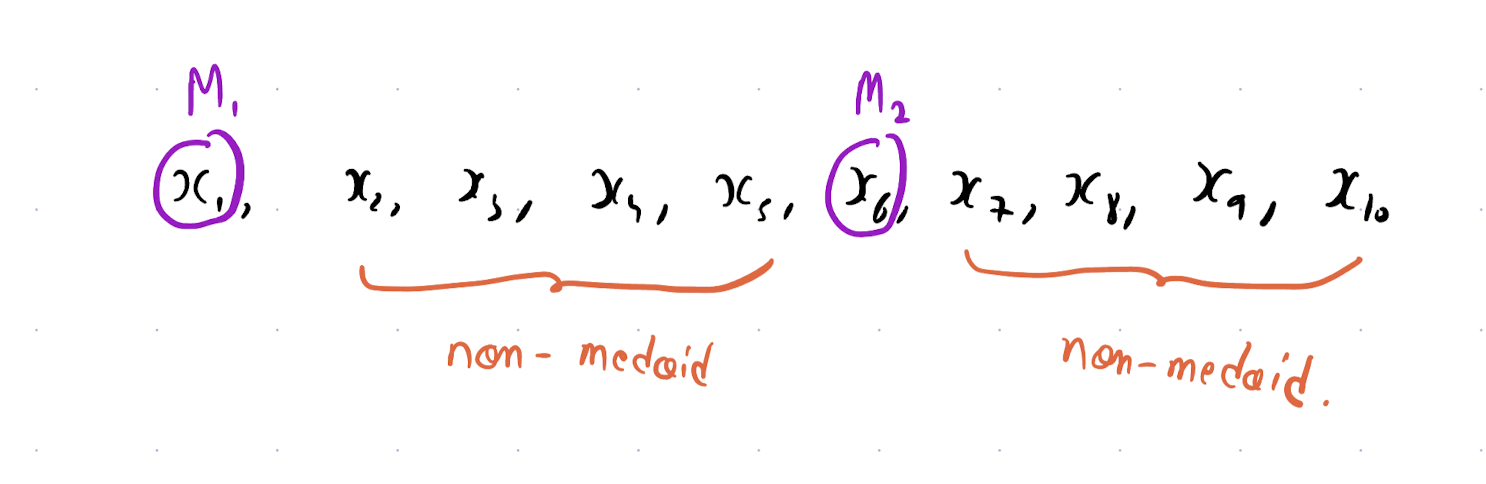

2. We compute Cost  (also known as dissimilarity) and
    - if cost decreases, keep the swap
    - else undo the swap

#### What's the cost/ loss in k-medoid?

Simple, it's total sum of distance

$$Loss = \sum_{i=1}^{K} \sum_{x_i \in S_j} \text{distance}(x_i, m_j)$$

$$Loss = \sum_{i=1}^{K} \sum_{x_i \in S_j} ||x_i -  m_j||^2$$

Notice that,
- we are trying to minimize intra cluster distance.


Note that
- distance can be eucld, manhattan, minkowski etc





First, we calculate loss value with
- $x_1, x_6$ as medoid

Say, this loss value comes out to be $l_1$

Now, we will swap medoid point with non medoid point
- asuume we made $M_1 = x_2$ and $M_2 = x_6$
- $M_2$ will remain the same

Notice that
- we only swapped single point i.e. $M_1$
- i.e. in one iteration, only single medoid is swapped with non medoid.
- Not all medoids are swapped.

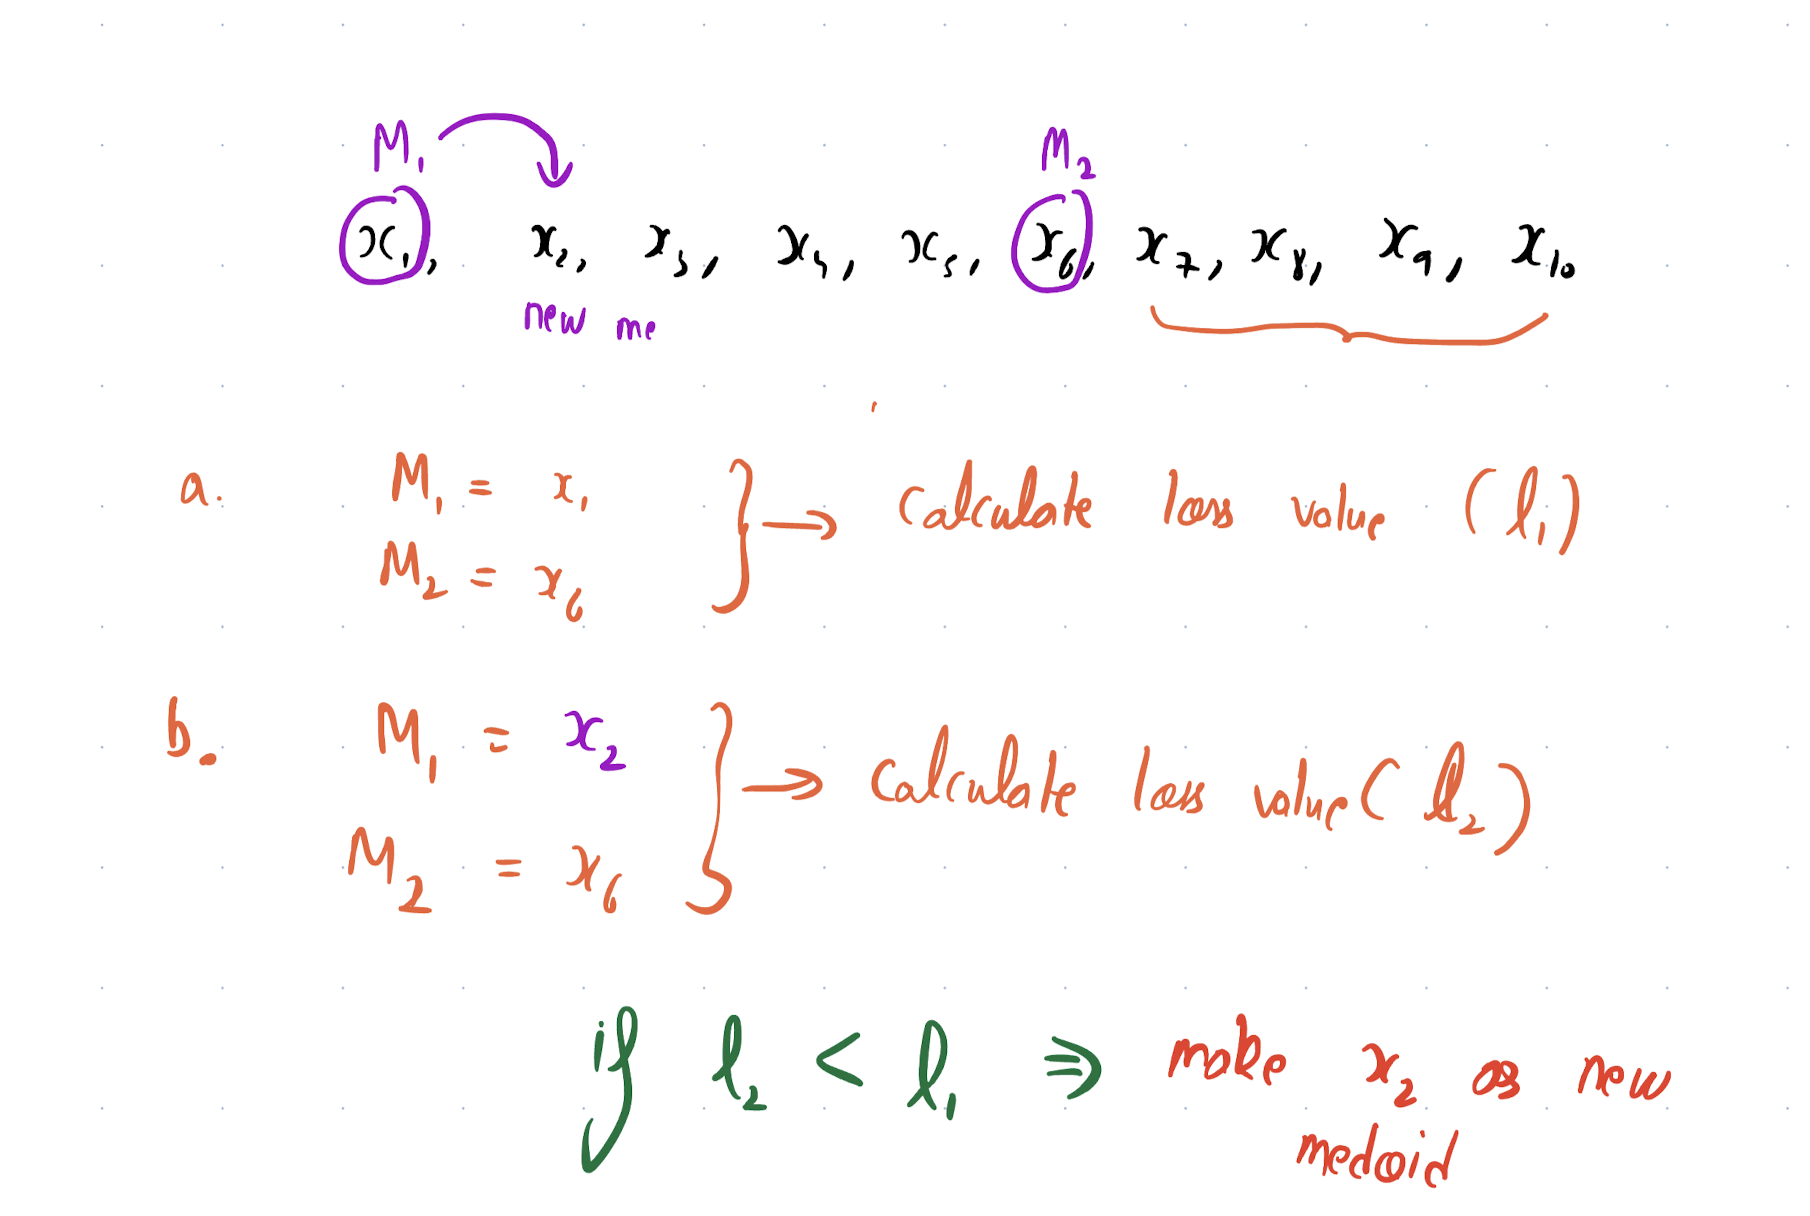

After swapping,
- we compute the loss ($l_2$)

If $l_2$ < $l_1$,
- we make $x_2$ as our new medoids


We will try all the swaps until there is no more beneficial swaps left
- or we have reached maximum number of iterations


#### What makes it better than other algo?


The massive advantage it holds over others is
- interpretibility
    - as medoids are the datapoints itself, so it is easy to understand and interpret them.

#### Any limitations ?

As we have to go through numerous swap and then
- compute the distances
- which makes Kmedoids slow

As the dataset grows, the computational demand will grow quadratically.
- So, it is better suited for small datasets.

Now, we understood that K-Means is initialization dependent and it cannot deal with data with differing size, density or if the data is spread over some weird shape (which will often be the case in real-life).

So, what can we do? Do we have anything other that can solve this problem?